# Data Preparation

## load data

In [1]:
import pandas as pd
import os

# pd.options.mode.copy_on_write = True


FILE_DIR = 'data_Energy_Germany'
FILE_NAME_PREFIX = 'Realised_Demand_Germany'
FILE_PATHS = [os.path.join(FILE_DIR, file)
              for file in os.listdir(FILE_DIR) if file.startswith(FILE_NAME_PREFIX)]

FILE_PATHS = FILE_PATHS[:1]  # todo: temp

TZ = 'Europe/Berlin'
SEP = ';'


def load_data():
    df = pd.concat((pd.read_csv(file_path, sep=SEP)
                    for file_path in FILE_PATHS), ignore_index=True)
    
    df.drop(['Residual Load [MWh]', 'Pumped Storage [MWh]', 'Date to'], axis=1, inplace=True)
    df.rename(columns={'Date from': 'date_from', 'Total (Grid Load) [MWh]': 'grid_load'}, inplace=True)
    
    # convert to datetime column
    df['date_from'] = pd.to_datetime(df['date_from'], format='%d.%m.%y %H:%M').dt.tz_localize(TZ, ambiguous='infer')
    
    # convert to float column
    df.grid_load = df.grid_load.str.replace('.', '').str.replace(',', '.')  # clean float representation
    df = df.astype({'grid_load': float})

    # report NAs
    for col in df.columns:
        if any(df.date_from.isna()):
            print(f'WARNING: Missing value in column {col} detected!')
    return df

df = load_data()
df.head()

,date_from,grid_load
0,2015-01-01 00:00:00+01:00,11210.00
1,2015-01-01 00:15:00+01:00,11118.75
2,2015-01-01 00:30:00+01:00,11144.75
3,2015-01-01 00:45:00+01:00,11126.75
4,2015-01-01 01:00:00+01:00,11009.50


In [2]:
GRID_LOAD_DICT = dict(zip(df.date_from, df.grid_load))

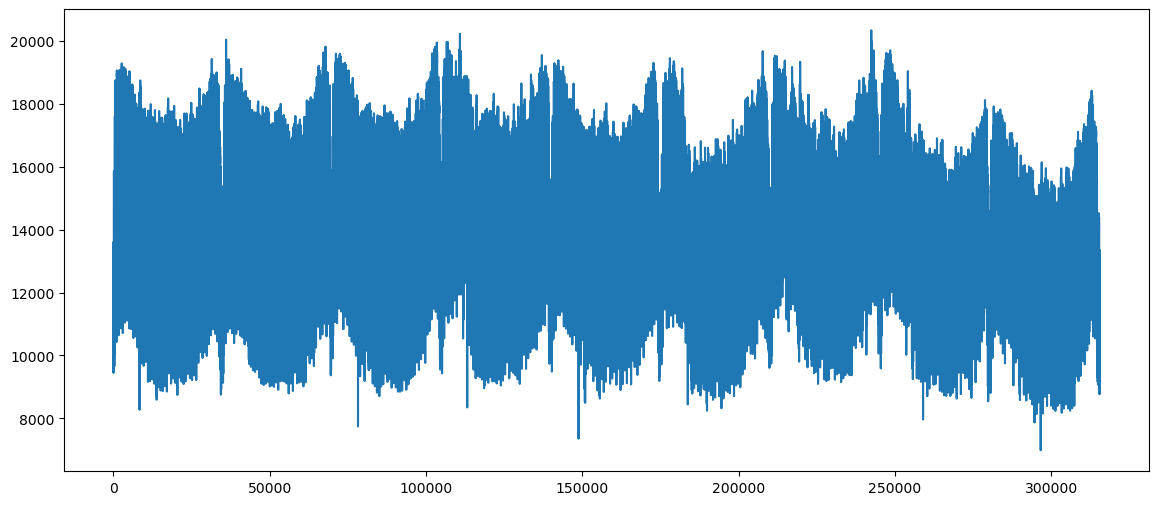

In [3]:
# PLOT DATA

import numpy as np
import matplotlib.pyplot as plt

def plot_data(df):
    data = np.array(df.grid_load)
    
    fig, ax = plt.subplots(figsize=(14,6))
    ax.plot(np.arange(data.size), data)
    plt.show()

plot_data(df)

## categorize days

In [4]:
from holidays.utils import country_holidays

YEARS = list(range(df.date_from.iloc[0].year, df.date_from.iloc[-1].year+1))
print(f'data contains years: {YEARS}')

def categorize_days(df):
    german_holidays = country_holidays('DE', years=YEARS)
    holiday_dates = set(german_holidays.keys())
    
    def is_sunday_or_holiday(timestamp):
        return timestamp.date() in holiday_dates or timestamp.day_name() == 'Sunday'
    
    def gen_saturday_col(df):
        return df.date_from.map(lambda ts: ts.day_name() == 'Saturday') & ~df.cat_is_sunday_or_holiday
    
    df = df.assign(cat_is_sunday_or_holiday=df.date_from.map(is_sunday_or_holiday))
    df = df.assign(cat_is_saturday_and_not_holiday=gen_saturday_col(df))
    df = df.assign(cat_is_workday=((~df.cat_is_sunday_or_holiday) & (~df.cat_is_saturday_and_not_holiday)))
    return df

df = categorize_days(df)
df.head()

data contains years: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


,date_from,grid_load,cat_is_sunday_or_holiday,cat_is_saturday_and_not_holiday,cat_is_workday
0,2015-01-01 00:00:00+01:00,11210.00,True,False,False
1,2015-01-01 00:15:00+01:00,11118.75,True,False,False
2,2015-01-01 00:30:00+01:00,11144.75,True,False,False
3,2015-01-01 00:45:00+01:00,11126.75,True,False,False
4,2015-01-01 01:00:00+01:00,11009.50,True,False,False


In [5]:
print('avg. value counts per year of cat cols:\n')
for col in df.columns:
    if col.startswith('cat_'):
        display(df[col].value_counts() // 8)  # per year
        print()

avg. value counts per year of cat cols:



cat_is_sunday_or_holiday
False    32916
True      6528
Name: count, dtype: int64

cat_is_saturday_and_not_holiday
False    33888
True      5556
Name: count, dtype: int64

cat_is_workday
True     27360
False    12084
Name: count, dtype: int64

## add heating period

In [6]:
def add_heating_period(df):
    # heating period is approx. from October to March
    month_april, month_september = 4, 9
    non_heating_period = range(month_april, month_september+1)
    df = df.assign(cat_is_heating_period=df.date_from.map(lambda ts: ts.month not in non_heating_period))
    return df

df = add_heating_period(df)
df.head()

,date_from,grid_load,cat_is_sunday_or_holiday,cat_is_saturday_and_not_holiday,cat_is_workday,cat_is_heating_period
0,2015-01-01 00:00:00+01:00,11210.00,True,False,False,True
1,2015-01-01 00:15:00+01:00,11118.75,True,False,False,True
2,2015-01-01 00:30:00+01:00,11144.75,True,False,False,True
3,2015-01-01 00:45:00+01:00,11126.75,True,False,False,True
4,2015-01-01 01:00:00+01:00,11009.50,True,False,False,True


## add lagged time stamps

In [7]:
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from functools import partial

from timeit import default_timer

# warning: takes a while... 1-2 min on my laptop

# note: leap year handled by reusing values from 28th of February

# use *positive* timedeltas or relativedeltas. Use relativedeltas only for deltas >= 1 year.
LAGS = {
    'last_year': relativedelta(years=+1),
    'last_week': timedelta(weeks=+1),
    'yesterday': timedelta(days=+1),
    'last_hour': timedelta(hours=+1),
}

TS_COLS = [f'ts_{col_name}' for col_name in LAGS]

def add_lagged_ts(df, lags):
    df.rename(columns={'date_from': 'ts_pred', 'grid_load': 'load_to_pred'}, inplace=True)

    # shift_func = partial(add_timedelta, td=-lag
    # lagged_cols = {
    #     f'ts_{col_name}': df.ts_pred.map(lambda ts: add_timedelta(ts, -lag))
    #     for col_name, lag in lags.items()
    # }
    lagged_cols = {}
    for col_name, lag in lags.items():
        t1 = default_timer()
        print(f'adding {col_name}...')
        lagged_col = df.ts_pred - lag if isinstance(lag, timedelta) else df.ts_pred.map(lambda ts: ts - lag)
        lagged_cols[f'ts_{col_name}'] = lagged_col
        t2 = default_timer()
        print(f'done. took {t2-t1}s.')
    df = df.assign(**lagged_cols)
    
    df.dropna(inplace=True, ignore_index=True)
    return df

def add_timedelta(ts, td):
    # based on: https://www.hacksoft.io/blog/handling-timezone-and-dst-changes-with-python
    ts_utc = ts.astimezone('UTC')
    ts_shifted_utc = ts_utc + td
    ts_shifted = ts_shifted_utc.astimezone(TZ)
    dst_offset_diff = ts.dst() - ts_shifted.dst()
    ts_shifted += dst_offset_diff
    return ts_shifted


df = add_lagged_ts(df, LAGS)
df.head()

adding last_year...
done. took 73.07262089999858s.
adding last_week...
done. took 0.010280700000294019s.
adding yesterday...
done. took 0.009204000001773238s.
adding last_hour...
done. took 0.009086199999728706s.


,ts_pred,load_to_pred,cat_is_sunday_or_holiday,cat_is_saturday_and_not_holiday,cat_is_workday,cat_is_heating_period,ts_last_year,ts_last_week,ts_yesterday,ts_last_hour
0,2015-01-01 00:00:00+01:00,11210.00,True,False,False,True,2014-01-01 00:00:00+01:00,2014-12-25 00:00:00+01:00,2014-12-31 00:00:00+01:00,2014-12-31 23:00:00+01:00
1,2015-01-01 00:15:00+01:00,11118.75,True,False,False,True,2014-01-01 00:15:00+01:00,2014-12-25 00:15:00+01:00,2014-12-31 00:15:00+01:00,2014-12-31 23:15:00+01:00
2,2015-01-01 00:30:00+01:00,11144.75,True,False,False,True,2014-01-01 00:30:00+01:00,2014-12-25 00:30:00+01:00,2014-12-31 00:30:00+01:00,2014-12-31 23:30:00+01:00
3,2015-01-01 00:45:00+01:00,11126.75,True,False,False,True,2014-01-01 00:45:00+01:00,2014-12-25 00:45:00+01:00,2014-12-31 00:45:00+01:00,2014-12-31 23:45:00+01:00
4,2015-01-01 01:00:00+01:00,11009.50,True,False,False,True,2014-01-01 01:00:00+01:00,2014-12-25 01:00:00+01:00,2014-12-31 01:00:00+01:00,2015-01-01 00:00:00+01:00


## remove OOB timestamps (due to shifting)

In [8]:
def remove_oob_ts(df, lags):
    ts_with_data_min, ts_with_data_max = df.ts_pred.min(), df.ts_pred.max()
    for col in TS_COLS:
        out_of_bounds_index = df[(df[col] < ts_with_data_min) | (df[col] > ts_with_data_max)].index
        df.drop(index=out_of_bounds_index, inplace=True)
    df = df.reset_index(drop=True)
    return df

df = remove_oob_ts(df, LAGS)
df

,ts_pred,load_to_pred,cat_is_sunday_or_holiday,cat_is_saturday_and_not_holiday,cat_is_workday,cat_is_heating_period,ts_last_year,ts_last_week,ts_yesterday,ts_last_hour
0,2016-01-01 00:00:00+01:00,11004.75,True,False,False,True,2015-01-01 00:00:00+01:00,2015-12-25 00:00:00+01:00,2015-12-31 00:00:00+01:00,2015-12-31 23:00:00+01:00
1,2016-01-01 00:15:00+01:00,10956.75,True,False,False,True,2015-01-01 00:15:00+01:00,2015-12-25 00:15:00+01:00,2015-12-31 00:15:00+01:00,2015-12-31 23:15:00+01:00
2,2016-01-01 00:30:00+01:00,10913.50,True,False,False,True,2015-01-01 00:30:00+01:00,2015-12-25 00:30:00+01:00,2015-12-31 00:30:00+01:00,2015-12-31 23:30:00+01:00
3,2016-01-01 00:45:00+01:00,10856.75,True,False,False,True,2015-01-01 00:45:00+01:00,2015-12-25 00:45:00+01:00,2015-12-31 00:45:00+01:00,2015-12-31 23:45:00+01:00
4,2016-01-01 01:00:00+01:00,10695.50,True,False,False,True,2015-01-01 01:00:00+01:00,2015-12-25 01:00:00+01:00,2015-12-31 01:00:00+01:00,2016-01-01 00:00:00+01:00
...,...,...,...,...,...,...,...,...,...,...
280507,2023-12-31 22:45:00+01:00,10782.00,True,False,False,True,2022-12-31 22:45:00+01:00,2023-12-24 22:45:00+01:00,2023-12-30 22:45:00+01:00,2023-12-31 21:45:00+01:00
280508,2023-12-31 23:00:00+01:00,10753.75,True,False,False,True,2022-12-31 23:00:00+01:00,2023-12-24 23:00:00+01:00,2023-12-30 23:00:00+01:00,2023-12-31 22:00:00+01:00
280509,2023-12-31 23:15:00+01:00,10606.75,True,False,False,True,2022-12-31 23:15:00+01:00,2023-12-24 23:15:00+01:00,2023-12-30 23:15:00+01:00,2023-12-31 22:15:00+01:00
280510,2023-12-31 23:30:00+01:00,10495.75,True,False,False,True,2022-12-31 23:30:00+01:00,2023-12-24 23:30:00+01:00,2023-12-30 23:30:00+01:00,2023-12-31 22:30:00+01:00


## timestamps to grid loads

In [9]:
def ts_to_loads(df):
    load_cols = {}
    for lag_name, ts_col_name in zip(LAGS, TS_COLS):
        print(f'converting {lag_name}...')
        t1 = default_timer()
        load_col = df[ts_col_name].map(lambda ts: GRID_LOAD_DICT[ts])
        load_cols[f'load_{lag_name}'] = load_col
        t2 = default_timer()
        print(f'done. took {t2-t1}s.')
    df = df.assign(**load_cols)
    
    # remove unneeded time stamp columns
    df.drop(TS_COLS, axis=1, inplace=True)
    return df

df = ts_to_loads(df)
df.head()

converting last_year...
done. took 2.1836468999972567s.
converting last_week...
done. took 2.1343541000023833s.
converting yesterday...
done. took 2.076488099999551s.
converting last_hour...
done. took 2.0558347000041977s.


,ts_pred,load_to_pred,cat_is_sunday_or_holiday,cat_is_saturday_and_not_holiday,cat_is_workday,cat_is_heating_period,load_last_year,load_last_week,load_yesterday,load_last_hour
0,2016-01-01 00:00:00+01:00,11004.75,True,False,False,True,11210.00,10178.50,11534.25,11505.00
1,2016-01-01 00:15:00+01:00,10956.75,True,False,False,True,11118.75,9967.75,11298.00,11351.50
2,2016-01-01 00:30:00+01:00,10913.50,True,False,False,True,11144.75,9769.50,11121.75,11250.25
3,2016-01-01 00:45:00+01:00,10856.75,True,False,False,True,11126.75,9563.50,10917.25,11175.25
4,2016-01-01 01:00:00+01:00,10695.50,True,False,False,True,11009.50,9419.25,10762.50,11004.75


## Add time of day features

### test/demo spline transformer

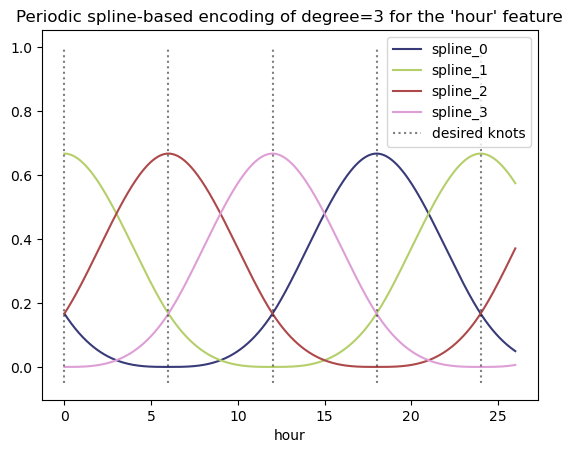

In [26]:
# based on/taken from https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#periodic-spline-features

from sklearn.preprocessing import SplineTransformer

DEGREES = [3]
N_SPLINES = 4

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

hour_df = pd.DataFrame(
    np.linspace(0, 26, 1000).reshape(-1, 1),
    columns=["hour"],
)
for deg in DEGREES:
    splines = periodic_spline_transformer(24, n_splines=N_SPLINES, degree=deg).fit_transform(hour_df)
    splines_df = pd.DataFrame(
        splines,
        columns=[f"spline_{i}" for i in range(splines.shape[1])],
    )
    pd.concat([hour_df, splines_df], axis="columns").plot(x="hour", cmap=plt.cm.tab20b)
    plt.vlines([0, 6, 12, 18, 24], -0.05, 1, label='desired knots', alpha=0.5, color='black', linestyle='dotted')
    plt.legend()
    _ = plt.title(f"Periodic spline-based encoding of degree={deg} for the 'hour' feature")

In [93]:
df_hours = df.ts_pred.map(lambda ts: ts.hour + ts.minute/60).to_frame()
df_hours

,ts_pred
0,0.00
1,0.25
2,0.50
3,0.75
4,1.00
...,...
105211,22.75
105212,23.00
105213,23.25
105214,23.50


C:\Users\Mischa\.conda\envs\masterarbeit\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SplineTransformer was fitted without feature names
  warnings.warn(


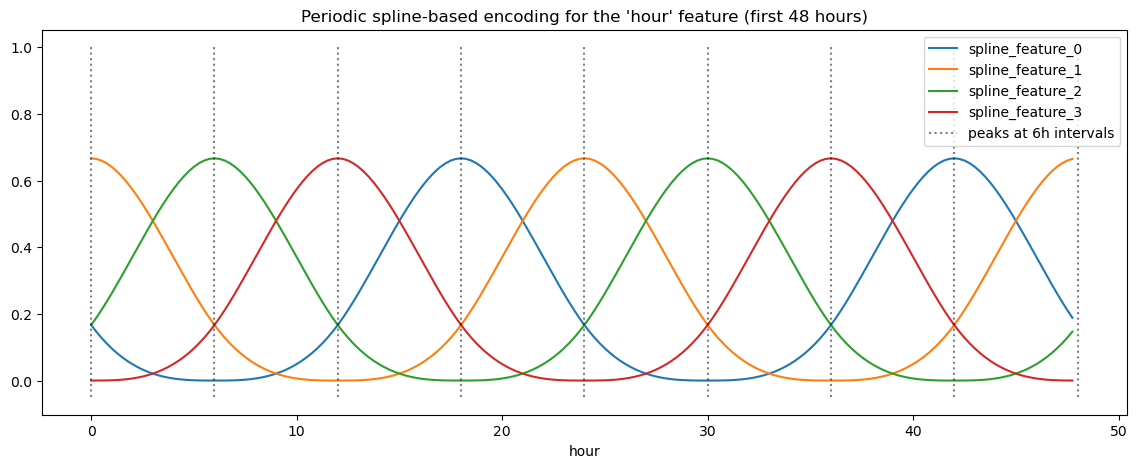

In [116]:
df_hours_values = np.array(sorted(set(df_hours['ts_pred'].values))).reshape(-1, 1)
splines_features = periodic_spline_transformer(period=24, n_splines=4, degree=3).fit(df_hours_values).transform(df_hours)
splines_df = pd.DataFrame(
    splines_features,
    columns=[f"spline_feature_{i}" for i in range(splines_features.shape[1])],
)

# plot subset
n_datapoints_per_hour = 4
plot_hours = 2 * 24
lim = plot_hours * n_datapoints_per_hour
fig, ax = plt.subplots(figsize=(14,5))
# ax.plot(df_hours.index[:lim], df_hours[:lim] / 24 / 5, label='hours')
ax.plot(df_hours.index[:lim]/n_datapoints_per_hour, splines_df[:lim], label=splines_df.columns)
ax.vlines(np.arange(0, plot_hours+1, 6), -0.05, 1, label='peaks at 6h intervals', alpha=0.5, color='black', linestyle='dotted')
ax.set_xlabel('hour')
plt.title(f"Periodic spline-based encoding for the 'hour' feature (first {plot_hours} hours)")
ax.legend()
plt.show()

## Save DF

In [10]:
def save_df(df, filename='data.pkl'):
    df.to_pickle(filename)

save_df(df)

## Mini Analysis

In [11]:
df.describe()

,load_to_pred,load_last_year,load_last_week,load_yesterday,load_last_hour
count,280512.000000,280512.000000,280512.000000,280512.000000,280512.000000
mean,14066.838613,14216.279229,14067.321073,14067.241474,14066.849794
std,2499.470587,2504.666792,2499.376865,2499.027682,2499.456509
min,6984.750000,7354.500000,6984.750000,6984.750000,6984.750000
25%,12020.000000,12139.750000,12020.000000,12020.250000,12020.000000
50%,13991.750000,14146.375000,13994.000000,13991.750000,13991.750000
75%,16129.500000,16325.750000,16129.500000,16129.500000,16129.500000
max,20341.500000,20341.500000,20341.500000,20341.500000,20341.500000


In [12]:
print('avg. value counts per year of cat cols:\n')
for col in df.columns:
    if col.startswith('cat_'):
        display(df[col].value_counts() // 8)  # per year
        print()

avg. value counts per year of cat cols:



cat_is_sunday_or_holiday
False    29268
True      5796
Name: count, dtype: int64

cat_is_saturday_and_not_holiday
False    30108
True      4956
Name: count, dtype: int64

cat_is_workday
True     24312
False    10752
Name: count, dtype: int64

cat_is_heating_period
False    17568
True     17496
Name: count, dtype: int64

## Optional: Add 2-year versions of data

In [13]:
# add 2-year versions of data
first_year, last_year = df.ts_pred.iloc[0].year, df.ts_pred.iloc[-1].year
df_years = df.ts_pred.map(lambda ts: ts.year)

years_range = range(first_year, last_year+1)
dfs_paired_years = []
for year1, year2 in zip(years_range, years_range[1:]):
    print(year1, year2)
    df_paired_years = df[(df_years == year1) | (df_years == year2)]
    df.to_pickle(f'data_{year1}_{year2}.pkl')

2016 2017
2017 2018
2018 2019
2019 2020
2020 2021
2021 2022
2022 2023


In [14]:
# stop for automatic run
1/0

ZeroDivisionError: division by zero

# Linear Regression

## load data

In [ ]:
# import importlib
# import energy_test

# importlib.reload(energy_test)

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split

from energy_test import df_to_input_output



def df_to_input_output(df, with_ts=False):
    input_cols = [
        'load_last_week',
        'load_yesterday',
        'load_last_hour',
    ]
    output_cols = ['load_to_pred']
    ts_cols = ['ts_pred']
    # input_cols = [col for col in df.columns
    #               if col not in output_cols + ts_cols]
    
    X = np.array(df[input_cols], dtype=float).reshape(-1, len(input_cols))  # (n_samples, n_features)
    y = np.array(df[output_cols], dtype=float).reshape(-1, len(output_cols))  # (n_samples, n_targets)
    ts = np.array(df[ts_cols]).reshape(-1, len(ts_cols))
    
    return (X, y, ts) if with_ts else (X, y)


df = pd.read_pickle('data.pkl')
X, y = df_to_input_output(df)  # convert df to np arrays
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
def my_plot():
    lim = 1000
    # X_col = 'load_last_hour'
    # y_col = 'load_to_pred'
    # X, y = df[X_col][-lim:], df[y_col][-lim:]

    X = X_train[:, 1]  # week, yesterday, hour
    y = y_train

    X = (X - X.mean())[-lim:]  #/ X.std()
    y = (y - y.mean())[-lim:]  #/ y.std()
    
    x_plot = np.arange(y.size)

    plt.figure(figsize=(14,6))
    plt.plot(x_plot, X, )
    plt.plot(x_plot, y, )
    plt.show()

my_plot()

## Run LinReg

In [ ]:
# TRAIN AND PLOTS

n_points = 300

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print(f"Mean squared error relative to mean true value: {mean_squared_error(y_test, y_pred) / y_test.mean():.5f}")

def plot():
    fig, ax = plt.subplots(figsize=(14,6))
    x_plot = np.arange(X_test.shape[0])
    ax.plot(x_plot[-n_points:], y_test[-n_points:], color="black", label='test data', linestyle='dotted')
    ax.plot(x_plot[-n_points:], X_test[-n_points:, 2], color="green", label='train data')
    ax.plot(x_plot[-n_points:], y_pred[-n_points:], color="blue", label='predicted data', alpha=0.5)
    plt.title('Test vs. Pred 1h ahead')
    plt.legend()
    plt.show()

plot()

In [ ]:
def plot():
    fig, ax = plt.subplots(figsize=(14,6))
    x_plot = np.arange(X_test.shape[0])
    ax.plot(x_plot[-n_points:], y_test[-n_points:], color="black", label='test data', linestyle='dotted')
    ax.plot(x_plot[-n_points:], X_test[-n_points:, 2], color="green", label='train data')
    ax.plot(x_plot[-n_points:], y_pred[-n_points:], color="blue", label='predicted data', alpha=0.5)
    plt.title('Test vs. Pred 1h ahead')
    plt.legend()
    plt.show()

plot()